<a href="https://colab.research.google.com/github/EMockevicius/EEG_emotion_recognition/blob/main/final_detecting_emotions_using_eeg_waves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> EEG Emotion Recognition <center>

In [ ]:
# pridedama prieiga prie google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Masters_colabs/EEG_emotion' #nuoroda į pagrindinį sistemos aplanką

In [2]:
#nuoroda į pagrindinį sistemos aplanką
folder_path = '/content/drive/MyDrive/Masters_colabs/EEG_emotion' 

In [ ]:
# nuskaitomas kaggle API failas (atsisiunčiamas asmeninis kaggle api failas turi būti įdėtas prie įgyvendinamo kodo)
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir data

In [ ]:
# Atsisiunčiamas duomenų rinkinys iš Kaggle

! kaggle datasets download -d birdy654/eeg-brainwave-dataset-feeling-emotions
! unzip eeg-brainwave-dataset-feeling-emotions.zip -d data

# Importing Libraries

In [7]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

### Reading EEG data with feature extracted 

In [8]:
data = pd.read_csv(folder_path+"/data/emotions.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [ ]:
data

### Viewing a sample of time series data 

In [9]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']

In [ ]:
fft_data

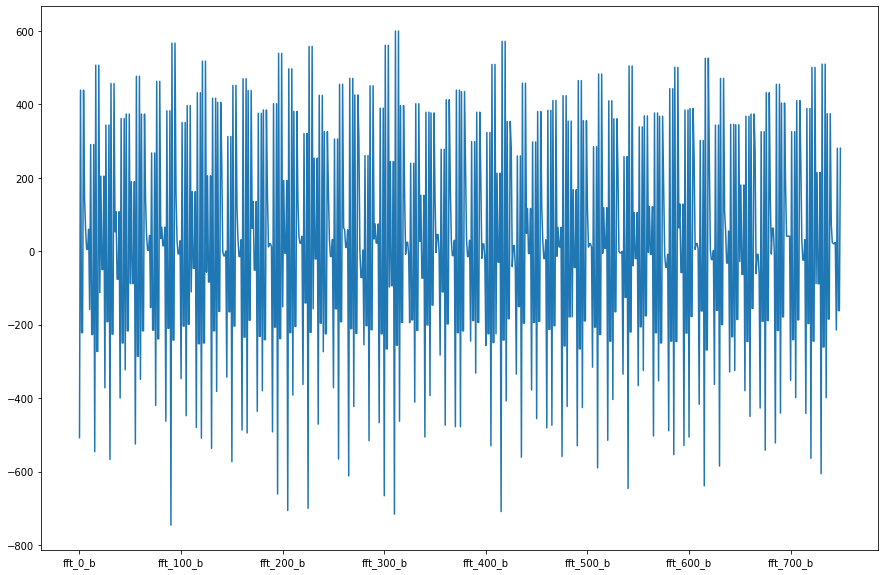

In [11]:
fft_data.iloc[0,:].plot(figsize=(15,10))

### Encoding the 3 distinct labels 

The 3 labels are : "NEGATIVE - 0", "NEUTRAL - 1" and "POSITIVE - 2".

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

In [13]:
data['label'].value_counts()

1    716
0    708
2    708
Name: label, dtype: int64

In [14]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

### Data preprocessing



In [16]:
y = data.pop('label')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

#pridedama 3-a dimensija X duomenyse siekiant pritaikyti prie GRU sluoksnio
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# First model 

In [15]:
def first_model(): # sudarytas pirminis Modelis

  inputs = tf.keras.Input(shape=(X_train.shape[1],1))

  gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
  
  flat = tf.keras.layers.Flatten()(gru)

  outputs = tf.keras.layers.Dense(3, activation='softmax')(flat)
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  opt_adam = keras.optimizers.Adam(learning_rate=0.001)
  
  model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])
    
  return model

In [17]:
# priskiriamas pirminis modelis prie model1
model1 = first_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548, 1)]         0         
                                                                 
 gru (GRU)                   (None, 2548, 256)         198912    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense (Dense)               (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


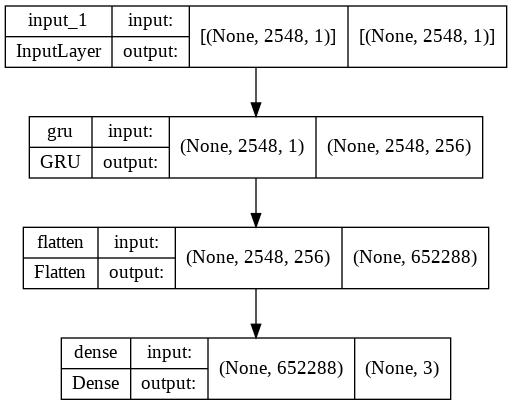

In [18]:
# atvaizduojama galutinio modelio architektūra:
print(model1.summary())

keras.utils.plot_model(model1, to_file="model1.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Second model

In [19]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional, CuDNNLSTM

In [20]:
def second_model(): # sudarytas antrasis modelis su LSTM
  dropout = .1

  inputs = tf.keras.Input(shape=(X_train.shape[1],1))

  lstm1 = tf.keras.layers.Bidirectional(CuDNNLSTM(128, return_sequences=True))(inputs)
  drop1 = tf.keras.layers.Dropout(dropout)(lstm1)

  dense1 = tf.keras.layers.Dense(15)(drop1)
  elu1 = tf.keras.layers.ELU()(dense1)
  drop2 = tf.keras.layers.Dropout(dropout)(elu1)
  flat = tf.keras.layers.Flatten()(drop2)

  outputs = tf.keras.layers.Dense(3, activation='softmax')(flat) #sigmoid / softmax 
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer = 'adam',
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])
  return model

In [21]:
# priskiriamas antrasis modelis prie model2
model2 = second_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2548, 1)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 2548, 256)        134144    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2548, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 2548, 15)          3855      
                                                                 
 elu (ELU)                   (None, 2548, 15)          0         
                                                                 
 dropout_1 (Dropout)         (None, 2548, 15)          0         
                                                           

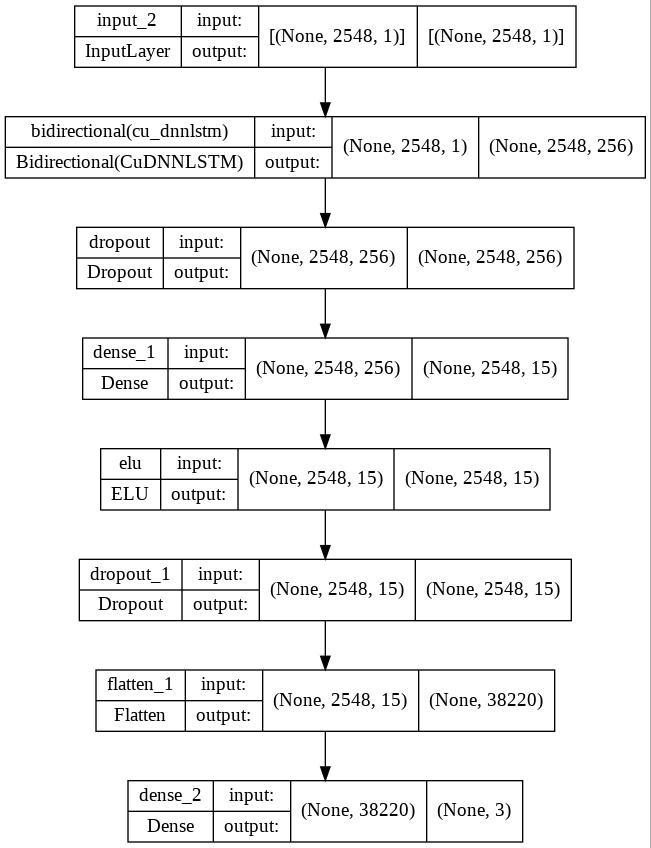

In [22]:
# atvaizduojama antrojo modelio architektūra:
print(model2.summary())


keras.utils.plot_model(model2, to_file="model2.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Third model

In [23]:
def third_model():   # sudaromas trečiasis modelis su GRU ir sparce_categorical_crossentropy 
   opt_adam = keras.optimizers.Adam(learning_rate=0.001)
   
   inputs = tf.keras.Input(shape=(X_train.shape[1],))
   
   expand_dims = tf.expand_dims(inputs, axis=2)
   
   gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
   
   flatten = tf.keras.layers.Flatten()(gru)
   
   outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)
   
   model = tf.keras.Model(inputs=inputs, outputs=outputs)
   
   model.compile(optimizer=opt_adam,
                 loss=['sparse_categorical_crossentropy'],
                 metrics=['accuracy'])   
   return model

In [24]:
# priskiriamas trečiasis Modelis prie model3
model3 = third_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2548, 1)          0         
                                                                 
 gru_1 (GRU)                 (None, 2548, 256)         198912    
                                                                 
 flatten_2 (Flatten)         (None, 652288)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


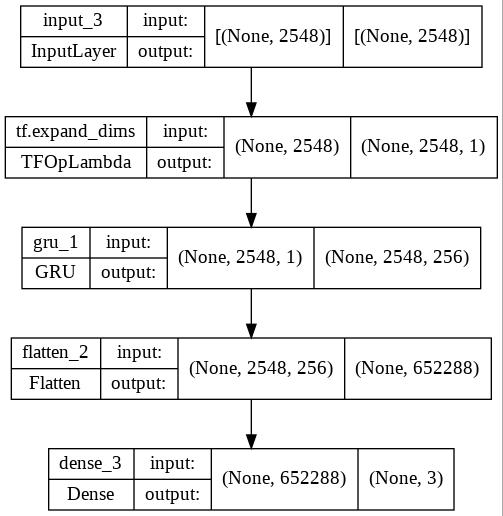

In [25]:
# atvaizduojama trečiojo modelio architektūra:
print(model3.summary())


keras.utils.plot_model(model3, to_file="model3.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Training function

In [26]:
# nurodomi mokymo parametrai
epoch = 50
batches = 16
es_patience = 10

In [27]:
def train_model(model,x_train, y_train,x_test,y_test, epoch, batches,es_patience, save_to):

        #opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience, restore_best_weights=True)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        #model.compile(optimizer=opt_adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=batches,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

# Training original model

In [29]:
%%time
model1,history = train_model(model1, X_train, y_train,X_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 18.2567 - accuracy: 0.8510
Epoch 1: val_accuracy improved from -inf to 0.90398, saving model to ./_best_model.h5
107/107 [==============================] - 12s 115ms/step - loss: 18.2567 - accuracy: 0.8510 - val_loss: 4.1028 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 3.5265 - accuracy: 0.9466
Epoch 2: val_accuracy did not improve from 0.90398
107/107 [==============================] - 11s 105ms/step - loss: 3.5265 - accuracy: 0.9466 - val_loss: 14.1248 - val_accuracy: 0.8735 - lr: 9.0484e-04
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 5.9238 - accuracy: 0.9437
Epoch 3: val_accuracy improved from 0.90398 to 0.96019, saving model to ./_best_model.h5
107/107 [==============================] - 12s 113ms/step - loss: 5.9238 - accuracy: 0.9437 - val_loss: 3.1997 - val_accuracy: 0.9602 - lr: 8.1873e-04
Epoch 4/50
107/107 [==============

# Evaluation of original model


In [30]:
model_acc1 = model1.evaluate(X_test, y_test, verbose=0)[1]

In [31]:
print("original models test Accuracy: {:.3f}%".format(model_acc1 * 100))

original models test Accuracy: 98.361%


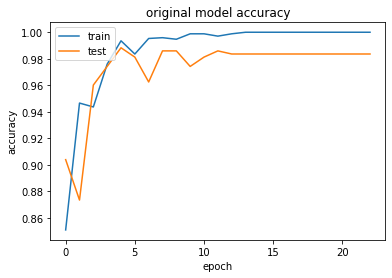

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('original model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

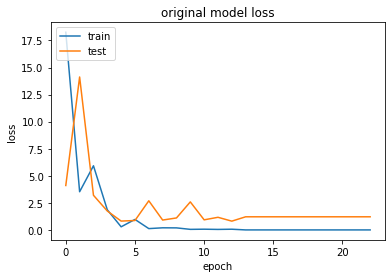

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('original model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# predicting on test data.
y_pred = np.array(list(map(lambda x: np.argmax(x), model1.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

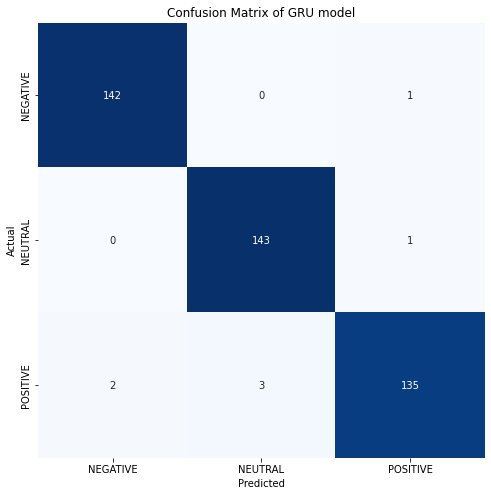

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       143
     NEUTRAL       0.98      0.99      0.99       144
    POSITIVE       0.99      0.96      0.97       140

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



In [35]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of GRU model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Training second model

In [36]:
# iš naujo paruošiami naudojami duomenys
data = pd.read_csv(folder_path+"/data/emotions.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

In [38]:
data['label'].value_counts()

1    716
0    708
2    708
Name: label, dtype: int64

In [39]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [40]:
y = data.pop('label')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

#pridedama 3-a dimensija X duomenyse siekiant pritaikyti prie GRU sluoksnio
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [41]:
%%time
model2,history = train_model(model2, X_train, y_train,X_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8933
Epoch 1: val_accuracy improved from -inf to 0.97892, saving model to ./_best_model.h5
107/107 [==============================] - 30s 261ms/step - loss: 0.3491 - accuracy: 0.8933 - val_loss: 0.0609 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9889
Epoch 2: val_accuracy did not improve from 0.97892
107/107 [==============================] - 27s 250ms/step - loss: 0.0345 - accuracy: 0.9889 - val_loss: 0.0487 - val_accuracy: 0.9789 - lr: 9.0484e-04
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9953
Epoch 3: val_accuracy improved from 0.97892 to 0.98595, saving model to ./_best_model.h5
107/107 [==============================] - 27s 257ms/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 0.0478 - val_accuracy: 0.9859 - lr: 8.1873e-04
Epoch 4/50
107/107 [=================

# Evaluation of second model

In [42]:
model_acc2 = model2.evaluate(X_test, y_test, verbose=0)[1]

In [43]:
print("LSTM test Accuracy: {:.3f}%".format(model_acc2 * 100))

LSTM test Accuracy: 99.063%


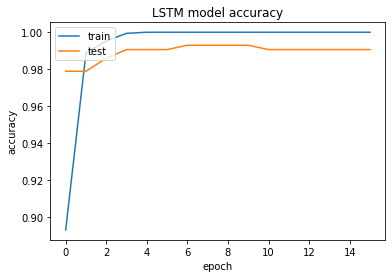

In [44]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

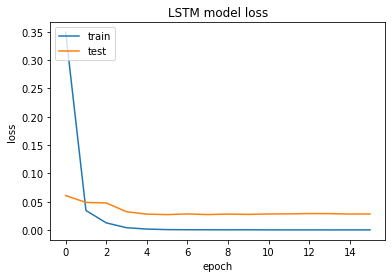

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# predicting on test data.
y_pred = np.array(list(map(lambda x: np.argmax(x), model2.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

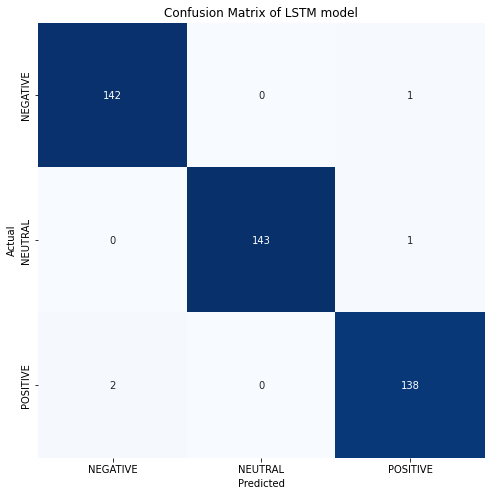

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       143
     NEUTRAL       1.00      0.99      1.00       144
    POSITIVE       0.99      0.99      0.99       140

    accuracy                           0.99       427
   macro avg       0.99      0.99      0.99       427
weighted avg       0.99      0.99      0.99       427



In [47]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of LSTM model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

#Training third model

In [48]:
# iš naujo paruošiami naudojami duomenys
data = pd.read_csv(folder_path+"/data/emotions.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [49]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [50]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [51]:
    data = data.copy()
    
    data['label'] = data['label'].replace(label_mapping)
    
    y = data['label'].copy()
    X = data.drop('label', axis=1).copy() 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

In [53]:
# training third model
%%time
model3,history = train_model(model3, X_train, y_train,X_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 21.7332 - accuracy: 0.8452
Epoch 1: val_accuracy improved from -inf to 0.95550, saving model to ./_best_model.h5
107/107 [==============================] - 13s 108ms/step - loss: 21.7332 - accuracy: 0.8452 - val_loss: 1.8587 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 4.1972 - accuracy: 0.9349
Epoch 2: val_accuracy did not improve from 0.95550
107/107 [==============================] - 11s 105ms/step - loss: 4.1972 - accuracy: 0.9349 - val_loss: 10.3654 - val_accuracy: 0.8665 - lr: 9.0484e-04
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 1.8918 - accuracy: 0.9672
Epoch 3: val_accuracy improved from 0.95550 to 0.96487, saving model to ./_best_model.h5
107/107 [==============================] - 12s 111ms/step - loss: 1.8918 - accuracy: 0.9672 - val_loss: 3.0444 - val_accuracy: 0.9649 - lr: 8.1873e-04
Epoch 4/50
107/107 [==============

# Evaluation of third model

In [54]:
model_acc3 = model3.evaluate(X_test, y_test, verbose=0)[1]

In [55]:
print("sparse GRU models test Accuracy: {:.3f}%".format(model_acc3 * 100))

sparse GRU models test Accuracy: 98.595%


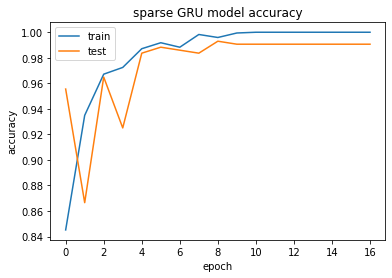

In [56]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('sparse GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

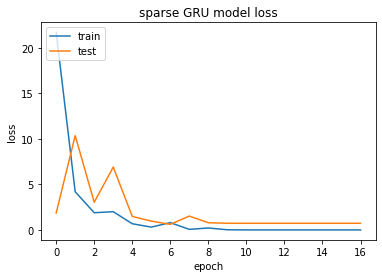

In [57]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('sparse GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
# predicting on test data.
y_pred = np.array(list(map(lambda x: np.argmax(x), model3.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

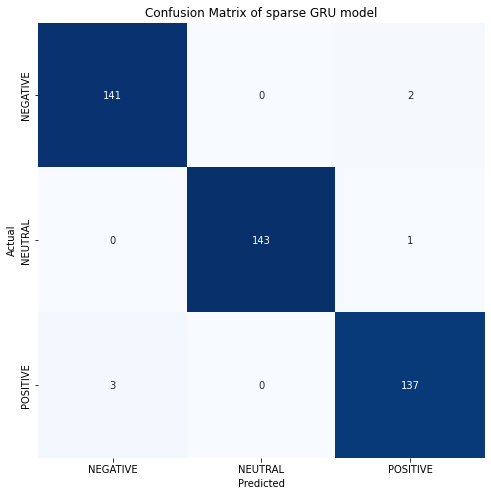

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.99      0.98       143
     NEUTRAL       1.00      0.99      1.00       144
    POSITIVE       0.98      0.98      0.98       140

    accuracy                           0.99       427
   macro avg       0.99      0.99      0.99       427
weighted avg       0.99      0.99      0.99       427



In [59]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of sparse GRU model")
plt.show()

print("Classification Report:\n----------------------\n", clr)